# Determine if a unit is providing marginal power

In [26]:
%matplotlib inline
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gzip
import cPickle as pickle

## Method
For every hour, find the change in **net** load from the previous hour. Net load is defined as total load minus wind generation.

### Change in net load
Use ERCOT data on hourly load and hourly wind generation to create `Net Load` and `Net Change` columns.

In [50]:
filename = 'ERCOT wind data.csv'
path = '../Clean Data'
fullpath = os.path.join(path, filename)
ercot = pd.read_csv(fullpath, index_col=0)

In [51]:
ercot.head()

,"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change
2007-01-01 00:00:00,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN
2007-01-01 01:00:00,30133.0,2790.0,922.6,33.068100,3.061760,-151.4,-14.096834
2007-01-01 02:00:00,29941.0,2790.0,849.2,30.437276,2.836245,-73.4,-7.955777
2007-01-01 03:00:00,29949.0,2790.0,1056.3,37.860215,3.526996,207.1,24.387659
2007-01-01 04:00:00,30248.0,2790.0,837.1,30.003584,2.767456,-219.2,-20.751680


In [52]:
ercot.loc[:,'Net Load'] = ercot.loc[:,'ERCOT Load, MW'] - ercot.loc[:,'Total Wind Output, MW']

In [53]:
ercot.head()

,"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change,Net Load
2007-01-01 00:00:00,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN,29354.0
2007-01-01 01:00:00,30133.0,2790.0,922.6,33.068100,3.061760,-151.4,-14.096834,29210.4
2007-01-01 02:00:00,29941.0,2790.0,849.2,30.437276,2.836245,-73.4,-7.955777,29091.8
2007-01-01 03:00:00,29949.0,2790.0,1056.3,37.860215,3.526996,207.1,24.387659,28892.7
2007-01-01 04:00:00,30248.0,2790.0,837.1,30.003584,2.767456,-219.2,-20.751680,29410.9


In [54]:
ercot.loc[1:,'Net Change'] = ercot.iloc[1:,-1].values - ercot.iloc[:-1,-1].values

In [55]:
ercot.head()

,"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change,Net Load,Net Change
2007-01-01 00:00:00,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN,29354.0,NaN
2007-01-01 01:00:00,30133.0,2790.0,922.6,33.068100,3.061760,-151.4,-14.096834,29210.4,-143.6
2007-01-01 02:00:00,29941.0,2790.0,849.2,30.437276,2.836245,-73.4,-7.955777,29091.8,-118.6
2007-01-01 03:00:00,29949.0,2790.0,1056.3,37.860215,3.526996,207.1,24.387659,28892.7,-199.1
2007-01-01 04:00:00,30248.0,2790.0,837.1,30.003584,2.767456,-219.2,-20.751680,29410.9,518.2


### EPA data
Calculate the change in generation for each plant in every hour. By summing the change across all plants in a group (cluster), we will have the change in generation for that group from the previous hour to the current hour. 

In [27]:
# load a zipped pickle file 
# from http://stackoverflow.com/questions/18474791/decreasing-the-size-of-cpickle-objects
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [28]:
filename = 'EPA hourly dictionary.pgz'
path = '../Clean Data'
fullpath = os.path.join(path, filename)

epaDict = load_zipped_pickle(fullpath)

In [29]:
epaDict.keys()

['2012 Jan-June',
 '2007 July-Dec',
 '2013 Jan-June',
 '2008 July-Dec',
 '2011 Jan-June',
 '2010 Jan-June',
 '2010 July-Dec',
 '2009 July-Dec',
 '2015 Jan-June',
 '2015 July-Dec',
 '2012 July-Dec',
 '2007 Jan-June',
 '2008 Jan-June',
 '2011 July-Dec',
 '2014 Jan-June',
 '2014 July-Dec',
 '2009 Jan-June',
 '2013 July-Dec']

In [35]:
for df in epaDict.values():
    df.head()

,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),HEAT INPUT (MMBTU),EPA REGION,NERC REGION,COUNTY,FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME
0,TX,Barney M. Davis,4939,2012,2012-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2012-01-01 00:00:00
1,TX,Barney M. Davis,4939,2012,2012-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2012-01-01 01:00:00
2,TX,Barney M. Davis,4939,2012,2012-01-01,2,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2012-01-01 02:00:00
3,TX,Barney M. Davis,4939,2012,2012-01-01,3,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2012-01-01 03:00:00
4,TX,Barney M. Davis,4939,2012,2012-01-01,4,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2012-01-01 04:00:00


,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),HEAT INPUT (MMBTU),EPA REGION,NERC REGION,COUNTY,FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME
0,TX,"AES Western Power, LLC",3461,2007,2007-07-01,0,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Harris,29.7239,-95.2258,2007-07-01 00:00:00
1,TX,"AES Western Power, LLC",3461,2007,2007-07-01,1,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Harris,29.7239,-95.2258,2007-07-01 01:00:00
2,TX,"AES Western Power, LLC",3461,2007,2007-07-01,2,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Harris,29.7239,-95.2258,2007-07-01 02:00:00
3,TX,"AES Western Power, LLC",3461,2007,2007-07-01,3,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Harris,29.7239,-95.2258,2007-07-01 03:00:00
4,TX,"AES Western Power, LLC",3461,2007,2007-07-01,4,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Harris,29.7239,-95.2258,2007-07-01 04:00:00


,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),HEAT INPUT (MMBTU),EPA REGION,NERC REGION,COUNTY,FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME
0,TX,Barney M. Davis,4939,2013,2013-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2013-01-01 00:00:00
1,TX,Barney M. Davis,4939,2013,2013-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2013-01-01 01:00:00
2,TX,Barney M. Davis,4939,2013,2013-01-01,2,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2013-01-01 02:00:00
3,TX,Barney M. Davis,4939,2013,2013-01-01,3,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2013-01-01 03:00:00
4,TX,Barney M. Davis,4939,2013,2013-01-01,4,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2013-01-01 04:00:00


,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),EPA REGION,NERC REGION,COUNTY,HEAT INPUT (MMBTU),FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME
0,TX,"AES Western Power, LLC",3461,2008,2008-07-01,0,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Harris,NaN,29.7239,-95.2258,2008-07-01 00:00:00
1,TX,"AES Western Power, LLC",3461,2008,2008-07-01,1,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Harris,NaN,29.7239,-95.2258,2008-07-01 01:00:00
2,TX,"AES Western Power, LLC",3461,2008,2008-07-01,2,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Harris,NaN,29.7239,-95.2258,2008-07-01 02:00:00
3,TX,"AES Western Power, LLC",3461,2008,2008-07-01,3,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Harris,NaN,29.7239,-95.2258,2008-07-01 03:00:00
4,TX,"AES Western Power, LLC",3461,2008,2008-07-01,4,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Harris,NaN,29.7239,-95.2258,2008-07-01 04:00:00


,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),HEAT INPUT (MMBTU),EPA REGION,NERC REGION,COUNTY,FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME
0,TX,Barney M. Davis,4939,2011,2011-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2011-01-01 00:00:00
1,TX,Barney M. Davis,4939,2011,2011-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2011-01-01 01:00:00
2,TX,Barney M. Davis,4939,2011,2011-01-01,2,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2011-01-01 02:00:00
3,TX,Barney M. Davis,4939,2011,2011-01-01,3,0.0,NaN,0.000,0.0,0.018,0.306,6,ERCOT,Nueces,27.6067,-97.3119,2011-01-01 03:00:00
4,TX,Barney M. Davis,4939,2011,2011-01-01,4,20.0,NaN,0.385,178.5,38.200,642.100,6,ERCOT,Nueces,27.6067,-97.3119,2011-01-01 04:00:00


,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),EPA REGION,NERC REGION,COUNTY,HEAT INPUT (MMBTU),FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME
0,TX,Barney M. Davis,4939,2010,2010-01-01,0,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2010-01-01 00:00:00
1,TX,Barney M. Davis,4939,2010,2010-01-01,1,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2010-01-01 01:00:00
2,TX,Barney M. Davis,4939,2010,2010-01-01,2,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2010-01-01 02:00:00
3,TX,Barney M. Davis,4939,2010,2010-01-01,3,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2010-01-01 03:00:00
4,TX,Barney M. Davis,4939,2010,2010-01-01,4,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2010-01-01 04:00:00


,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),HEAT INPUT (MMBTU),EPA REGION,NERC REGION,COUNTY,FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME
0,TX,Barney M. Davis,4939,2010,2010-07-01,0,329.0,NaN,1.511,30.300,149.60,2517.60,6,ERCOT,Nueces,27.6067,-97.3119,2010-07-01 00:00:00
1,TX,Barney M. Davis,4939,2010,2010-07-01,1,72.0,NaN,0.053,10.035,5.28,88.89,6,ERCOT,Nueces,27.6067,-97.3119,2010-07-01 01:00:00
2,TX,Barney M. Davis,4939,2010,2010-07-01,2,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2010-07-01 02:00:00
3,TX,Barney M. Davis,4939,2010,2010-07-01,3,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2010-07-01 03:00:00
4,TX,Barney M. Davis,4939,2010,2010-07-01,4,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2010-07-01 04:00:00


,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),HEAT INPUT (MMBTU),EPA REGION,NERC REGION,COUNTY,FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME
0,TX,Barney M. Davis,4939,2009,2009-07-01,0,1.0,NaN,0.072,3.6,7.2,120.4,6,ERCOT,Nueces,27.6067,-97.3119,2009-07-01 00:00:00
1,TX,Barney M. Davis,4939,2009,2009-07-01,1,1.0,NaN,0.069,3.8,6.9,115.3,6,ERCOT,Nueces,27.6067,-97.3119,2009-07-01 01:00:00
2,TX,Barney M. Davis,4939,2009,2009-07-01,2,1.0,NaN,0.062,3.4,6.1,103.2,6,ERCOT,Nueces,27.6067,-97.3119,2009-07-01 02:00:00
3,TX,Barney M. Davis,4939,2009,2009-07-01,3,1.0,NaN,0.062,3.4,6.1,103.2,6,ERCOT,Nueces,27.6067,-97.3119,2009-07-01 03:00:00
4,TX,Barney M. Davis,4939,2009,2009-07-01,4,1.0,NaN,0.062,3.4,6.1,103.2,6,ERCOT,Nueces,27.6067,-97.3119,2009-07-01 04:00:00


,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),HEAT INPUT (MMBTU),EPA REGION,NERC REGION,COUNTY,FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME
0,TX,Barney M. Davis,4939,2015,2015-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2015-01-01 00:00:00
1,TX,Barney M. Davis,4939,2015,2015-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2015-01-01 01:00:00
2,TX,Barney M. Davis,4939,2015,2015-01-01,2,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2015-01-01 02:00:00
3,TX,Barney M. Davis,4939,2015,2015-01-01,3,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2015-01-01 03:00:00
4,TX,Barney M. Davis,4939,2015,2015-01-01,4,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2015-01-01 04:00:00


,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),EPA REGION,NERC REGION,COUNTY,HEAT INPUT (MMBTU),FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME
0,TX,Barney M. Davis,4939,2015,2015-07-01,0,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2015-07-01 00:00:00
1,TX,Barney M. Davis,4939,2015,2015-07-01,1,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2015-07-01 01:00:00
2,TX,Barney M. Davis,4939,2015,2015-07-01,2,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2015-07-01 02:00:00
3,TX,Barney M. Davis,4939,2015,2015-07-01,3,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2015-07-01 03:00:00
4,TX,Barney M. Davis,4939,2015,2015-07-01,4,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2015-07-01 04:00:00


,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),EPA REGION,NERC REGION,COUNTY,HEAT INPUT (MMBTU),FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME
0,TX,Barney M. Davis,4939,2012,2012-07-01,0,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2012-07-01 00:00:00
1,TX,Barney M. Davis,4939,2012,2012-07-01,1,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2012-07-01 01:00:00
2,TX,Barney M. Davis,4939,2012,2012-07-01,2,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2012-07-01 02:00:00
3,TX,Barney M. Davis,4939,2012,2012-07-01,3,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2012-07-01 03:00:00
4,TX,Barney M. Davis,4939,2012,2012-07-01,4,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2012-07-01 04:00:00


,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),EPA REGION,NERC REGION,COUNTY,HEAT INPUT (MMBTU),FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME
0,TX,"AES Western Power, LLC",3461,2007,2007-01-01,0,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Harris,NaN,29.7239,-95.2258,2007-01-01 00:00:00
1,TX,"AES Western Power, LLC",3461,2007,2007-01-01,1,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Harris,NaN,29.7239,-95.2258,2007-01-01 01:00:00
2,TX,"AES Western Power, LLC",3461,2007,2007-01-01,2,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Harris,NaN,29.7239,-95.2258,2007-01-01 02:00:00
3,TX,"AES Western Power, LLC",3461,2007,2007-01-01,3,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Harris,NaN,29.7239,-95.2258,2007-01-01 03:00:00
4,TX,"AES Western Power, LLC",3461,2007,2007-01-01,4,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Harris,NaN,29.7239,-95.2258,2007-01-01 04:00:00


,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),HEAT INPUT (MMBTU),EPA REGION,NERC REGION,COUNTY,FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME
0,TX,"AES Western Power, LLC",3461,2008,2008-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Harris,29.7239,-95.2258,2008-01-01 00:00:00
1,TX,"AES Western Power, LLC",3461,2008,2008-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Harris,29.7239,-95.2258,2008-01-01 01:00:00
2,TX,"AES Western Power, LLC",3461,2008,2008-01-01,2,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Harris,29.7239,-95.2258,2008-01-01 02:00:00
3,TX,"AES Western Power, LLC",3461,2008,2008-01-01,3,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Harris,29.7239,-95.2258,2008-01-01 03:00:00
4,TX,"AES Western Power, LLC",3461,2008,2008-01-01,4,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Harris,29.7239,-95.2258,2008-01-01 04:00:00


,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),EPA REGION,NERC REGION,COUNTY,HEAT INPUT (MMBTU),FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME
0,TX,Barney M. Davis,4939,2011,2011-07-01,0,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2011-07-01 00:00:00
1,TX,Barney M. Davis,4939,2011,2011-07-01,1,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2011-07-01 01:00:00
2,TX,Barney M. Davis,4939,2011,2011-07-01,2,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2011-07-01 02:00:00
3,TX,Barney M. Davis,4939,2011,2011-07-01,3,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2011-07-01 03:00:00
4,TX,Barney M. Davis,4939,2011,2011-07-01,4,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2011-07-01 04:00:00


,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),HEAT INPUT (MMBTU),EPA REGION,NERC REGION,COUNTY,FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME
0,TX,Barney M. Davis,4939,2014,2014-01-01,0,193.0,NaN,0.179,11.000,17.700,297.640,6,ERCOT,Nueces,27.6067,-97.3119,2014-01-01 00:00:00
1,TX,Barney M. Davis,4939,2014,2014-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2014-01-01 01:00:00
2,TX,Barney M. Davis,4939,2014,2014-01-01,2,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2014-01-01 02:00:00
3,TX,Barney M. Davis,4939,2014,2014-01-01,3,0.0,NaN,0.005,0.145,0.500,8.425,6,ERCOT,Nueces,27.6067,-97.3119,2014-01-01 03:00:00
4,TX,Barney M. Davis,4939,2014,2014-01-01,4,41.0,NaN,0.577,274.256,57.084,961.284,6,ERCOT,Nueces,27.6067,-97.3119,2014-01-01 04:00:00


,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),EPA REGION,NERC REGION,COUNTY,HEAT INPUT (MMBTU),FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME
0,TX,Barney M. Davis,4939,2014,2014-07-01,0,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2014-07-01 00:00:00
1,TX,Barney M. Davis,4939,2014,2014-07-01,1,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2014-07-01 01:00:00
2,TX,Barney M. Davis,4939,2014,2014-07-01,2,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2014-07-01 02:00:00
3,TX,Barney M. Davis,4939,2014,2014-07-01,3,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2014-07-01 03:00:00
4,TX,Barney M. Davis,4939,2014,2014-07-01,4,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2014-07-01 04:00:00


,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),HEAT INPUT (MMBTU),EPA REGION,NERC REGION,COUNTY,FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME
0,TX,Barney M. Davis,4939,2009,2009-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2009-01-01 00:00:00
1,TX,Barney M. Davis,4939,2009,2009-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2009-01-01 01:00:00
2,TX,Barney M. Davis,4939,2009,2009-01-01,2,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2009-01-01 02:00:00
3,TX,Barney M. Davis,4939,2009,2009-01-01,3,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2009-01-01 03:00:00
4,TX,Barney M. Davis,4939,2009,2009-01-01,4,NaN,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,27.6067,-97.3119,2009-01-01 04:00:00


,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),EPA REGION,NERC REGION,COUNTY,HEAT INPUT (MMBTU),FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME
0,TX,Barney M. Davis,4939,2013,2013-07-01,0,113.0,NaN,0.093,6.42,9.24,6,ERCOT,Nueces,155.415,27.6067,-97.3119,2013-07-01 00:00:00
1,TX,Barney M. Davis,4939,2013,2013-07-01,1,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2013-07-01 01:00:00
2,TX,Barney M. Davis,4939,2013,2013-07-01,2,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2013-07-01 02:00:00
3,TX,Barney M. Davis,4939,2013,2013-07-01,3,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2013-07-01 03:00:00
4,TX,Barney M. Davis,4939,2013,2013-07-01,4,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2013-07-01 04:00:00


In [37]:
test = epaDict['2012 Jan-June']

In [39]:
test.fillna(0, inplace=True)

In [72]:
test['GROSS LOAD (MW)'].head()
test['GROSS LOAD (MW)'].tail()
len(test['GROSS LOAD (MW)'])

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: GROSS LOAD (MW), dtype: float64

240235    319.0
240236    339.0
240237    264.0
240238    242.0
240239    196.0
Name: GROSS LOAD (MW), dtype: float64

240240

In [74]:
test['GROSS LOAD (MW)'].shift(1).head()
test['GROSS LOAD (MW)'].shift(1).tail()
len(test['GROSS LOAD (MW)'].shift(1))

0    NaN
1    0.0
2    0.0
3    0.0
4    0.0
Name: GROSS LOAD (MW), dtype: float64

240235    335.0
240236    319.0
240237    339.0
240238    264.0
240239    242.0
Name: GROSS LOAD (MW), dtype: float64

240240

In [78]:
def plant_gen_delta(df):
    """
    For every plant in the input df, calculate the change in gross load (MW)
    from the previous hour.
    
    input:
        df: dataframe of EPA clean air markets data
    return:
        df: concatanated list of dataframes
    """
    df_list = []
    for plant in df['PLANT_ID'].unique():
        temp = df.loc[df['PLANT_ID'] == plant,:]
        gen_change = temp.loc[:,'GROSS LOAD (MW)'].values - temp.loc[:,'GROSS LOAD (MW)'].shift(1).values
        temp.loc[:,'Gen Change'] = gen_change
        df_list.append(temp)
    return pd.concat(df_list)

In [79]:
plant_gen_delta(test)

,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),HEAT INPUT (MMBTU),EPA REGION,NERC REGION,COUNTY,FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME,Gen Change
0,TX,Barney M. Davis,4939,2012,2012-01-01,0,0.0,0.0,0.000,0.000,0.000,0.00,6,ERCOT,Nueces,27.6067,-97.3119,2012-01-01 00:00:00,NaN
1,TX,Barney M. Davis,4939,2012,2012-01-01,1,0.0,0.0,0.000,0.000,0.000,0.00,6,ERCOT,Nueces,27.6067,-97.3119,2012-01-01 01:00:00,0.0
2,TX,Barney M. Davis,4939,2012,2012-01-01,2,0.0,0.0,0.000,0.000,0.000,0.00,6,ERCOT,Nueces,27.6067,-97.3119,2012-01-01 02:00:00,0.0
3,TX,Barney M. Davis,4939,2012,2012-01-01,3,0.0,0.0,0.000,0.000,0.000,0.00,6,ERCOT,Nueces,27.6067,-97.3119,2012-01-01 03:00:00,0.0
4,TX,Barney M. Davis,4939,2012,2012-01-01,4,0.0,0.0,0.000,0.000,0.000,0.00,6,ERCOT,Nueces,27.6067,-97.3119,2012-01-01 04:00:00,0.0
5,TX,Barney M. Davis,4939,2012,2012-01-01,5,0.0,0.0,0.000,0.000,0.000,0.00,6,ERCOT,Nueces,27.6067,-97.3119,2012-01-01 05:00:00,0.0
6,TX,Barney M. Davis,4939,2012,2012-01-01,6,0.0,0.0,0.000,0.000,0.000,0.00,6,ERCOT,Nueces,27.6067,-97.3119,2012-01-01 06:00:00,0.0
7,TX,Barney M. Davis,4939,2012,2012-01-01,7,0.0,0.0,0.000,0.000,0.000,0.00,6,ERCOT,Nueces,27.6067,-97.3119,2012-01-01 07:00:00,0.0
8,TX,Barney M. Davis,4939,2012,2012-01-01,8,0.0,0.0,0.000,0.000,0.000,0.00,6,ERCOT,Nueces,27.6067,-97.3119,2012-01-01 08:00:00,0.0
9,TX,Barney M. Davis,4939,2012,2012-01-01,9,0.0,0.0,0.000,0.000,0.000,0.00,6,ERCOT,Nueces,27.6067,-97.3119,2012-01-01 09:00:00,0.0


In [80]:
allEPA = pd.concat(epaDict)

In [81]:
allEPA.fillna(0, inplace=True)
allEPA.head()

CO2 (SHORT TONS)  COUNTY       DATE            DATETIME  \
2007 Jan-June 0               0.0  Harris 2007-01-01 2007-01-01 00:00:00   
              1               0.0  Harris 2007-01-01 2007-01-01 01:00:00   
              2               0.0  Harris 2007-01-01 2007-01-01 02:00:00   
              3               0.0  Harris 2007-01-01 2007-01-01 03:00:00   
              4               0.0  Harris 2007-01-01 2007-01-01 04:00:00   

                 EPA REGION  FACILITY LATITUDE  FACILITY LONGITUDE  \
2007 Jan-June 0           6            29.7239            -95.2258   
              1           6            29.7239            -95.2258   
              2           6            29.7239            -95.2258   
              3           6            29.7239            -95.2258   
              4           6            29.7239            -95.2258   

                          FACILITY NAME  GROSS LOAD (MW)  HEAT INPUT (MMBTU)  \
2007 Jan-June 0  AES Western Power, LLC              0.0                 0.0   
              1  AES Western Power, LLC              0.0                 0.0   
              2  AES Western Power, LLC              0.0                 0.0   
              3  AES Western Power, LLC              0.0                 0.0   
              4  AES Western Power, LLC              0.0                 0.0   

                 HOUR NERC REGION  NOX (POUNDS)  PLANT_ID  SO2 (POUNDS) STATE  \
2007 Jan-June 0     0       ERCOT           0.0      3461           0.0    TX   
              1     1       ERCOT           0.0      3461           0.0    TX   
              2     2       ERCOT           0.0      3461           0.0    TX   
              3     3       ERCOT           0.0      3461           0.0    TX   
              4     4       ERCOT           0.0      3461           0.0    TX   

                 STEAM LOAD (1000LB/HR)  YEAR  
2007 Jan-June 0                     0.0  2007  
              1                     0.0  2007  
              2                     0.0  2007  
              3                     0.0  2007  
              4                     0.0  2007

In [82]:
allEPA = plant_gen_delta(allEPA)

In [83]:
allEPA.reset_index(drop=True, inplace=True)

In [85]:
allEPA.tail()

,CO2 (SHORT TONS),COUNTY,DATE,DATETIME,EPA REGION,FACILITY LATITUDE,FACILITY LONGITUDE,FACILITY NAME,GROSS LOAD (MW),HEAT INPUT (MMBTU),HOUR,NERC REGION,NOX (POUNDS),PLANT_ID,SO2 (POUNDS),STATE,STEAM LOAD (1000LB/HR),YEAR,Gen Change
4511875,395.801,Brazoria,2015-12-31,2015-12-31 19:00:00,6,29.0728,-95.745,Sweeny Cogeneration Facility,422.0,6660.4,19,ERCOT,174.4,55015,3.358,TX,0.0,2015,-1.0
4511876,397.101,Brazoria,2015-12-31,2015-12-31 20:00:00,6,29.0728,-95.745,Sweeny Cogeneration Facility,423.0,6681.5,20,ERCOT,153.7,55015,3.378,TX,0.0,2015,1.0
4511877,395.601,Brazoria,2015-12-31,2015-12-31 21:00:00,6,29.0728,-95.745,Sweeny Cogeneration Facility,420.0,6655.3,21,ERCOT,162.9,55015,3.364,TX,0.0,2015,-3.0
4511878,401.501,Brazoria,2015-12-31,2015-12-31 22:00:00,6,29.0728,-95.745,Sweeny Cogeneration Facility,420.0,6756.3,22,ERCOT,175.4,55015,3.383,TX,0.0,2015,0.0
4511879,403.300,Brazoria,2015-12-31,2015-12-31 23:00:00,6,29.0728,-95.745,Sweeny Cogeneration Facility,422.0,6787.3,23,ERCOT,156.4,55015,3.402,TX,0.0,2015,2.0


### Export EPA with change in generation

In [ ]:
filename = 'EPA with hourly gen change.csv'
path = '../Clean Data'
fullpath = os.path.join(path, filename)
allEPA.to_csv(fullpath)

### Plot the change in generation for plant id 298

In [86]:
plant_298 = allEPA.loc[allEPA['PLANT_ID'] == 298,:]

In [90]:
plant_298.tail()

,CO2 (SHORT TONS),COUNTY,DATE,DATETIME,EPA REGION,FACILITY LATITUDE,FACILITY LONGITUDE,FACILITY NAME,GROSS LOAD (MW),HEAT INPUT (MMBTU),HOUR,NERC REGION,NOX (POUNDS),PLANT_ID,SO2 (POUNDS),STATE,STEAM LOAD (1000LB/HR),YEAR,Gen Change
1617163,1504.3,Limestone,2015-12-31,2015-12-31 19:00:00,6,31.4219,-96.2525,Limestone,1552.0,13816.9,19,ERCOT,2418.4,298,5165.4,TX,0.0,2015,-39.0
1617164,1080.6,Limestone,2015-12-31,2015-12-31 20:00:00,6,31.4219,-96.2525,Limestone,1103.0,9925.9,20,ERCOT,1746.0,298,3614.5,TX,0.0,2015,-449.0
1617165,904.5,Limestone,2015-12-31,2015-12-31 21:00:00,6,31.4219,-96.2525,Limestone,903.0,8308.0,21,ERCOT,1690.4,298,2987.5,TX,0.0,2015,-200.0
1617166,913.6,Limestone,2015-12-31,2015-12-31 22:00:00,6,31.4219,-96.2525,Limestone,902.0,8391.6,22,ERCOT,1644.1,298,3046.2,TX,0.0,2015,-1.0
1617167,916.4,Limestone,2015-12-31,2015-12-31 23:00:00,6,31.4219,-96.2525,Limestone,901.0,8417.2,23,ERCOT,1575.6,298,3145.4,TX,0.0,2015,-1.0


In [91]:
plant_298.index = plant_298['DATETIME']

In [88]:
len(plant_298)
len(ercot)

78888

78889

In [89]:
ercot.tail()

,"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change,Net Load,Net Change
2015-12-31 19:00:00,39908.77734,16170.0,3824.932373,23.654498,9.584188,483.971191,14.485987,36083.844967,-1172.357911
2015-12-31 20:00:00,38736.85938,16170.0,4625.632813,28.606264,11.941166,800.700440,20.933715,34111.226567,-1972.618400
2015-12-31 21:00:00,37587.70313,16170.0,4957.714844,30.659956,13.189725,332.082031,7.179170,32629.988286,-1481.238281
2015-12-31 22:00:00,36356.26172,16170.0,4699.097656,29.060592,12.925140,-258.617188,-5.216460,31657.164064,-972.824222
2015-12-31 23:00:00,35150.33984,16170.0,4313.125000,26.673624,12.270507,-385.972656,-8.213761,30837.214840,-819.949224


In [93]:
test = pd.merge(ercot, plant_298, left_index=True, right_index=True)

In [94]:
test.head()

,"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change,Net Load,Net Change,CO2 (SHORT TONS),...,HEAT INPUT (MMBTU),HOUR,NERC REGION,NOX (POUNDS),PLANT_ID,SO2 (POUNDS),STATE,STEAM LOAD (1000LB/HR),YEAR,Gen Change
2007-01-01 00:00:00,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN,29354.0,NaN,1659.7,...,15245.2,0,ERCOT,2980.017,298,1902.5,TX,0.0,2007,NaN
2007-01-01 01:00:00,30133.0,2790.0,922.6,33.068100,3.061760,-151.4,-14.096834,29210.4,-143.6,1671.2,...,15350.9,1,ERCOT,2938.545,298,1924.9,TX,0.0,2007,36.0
2007-01-01 02:00:00,29941.0,2790.0,849.2,30.437276,2.836245,-73.4,-7.955777,29091.8,-118.6,1695.6,...,15574.5,2,ERCOT,2997.699,298,2236.8,TX,0.0,2007,16.0
2007-01-01 03:00:00,29949.0,2790.0,1056.3,37.860215,3.526996,207.1,24.387659,28892.7,-199.1,1695.9,...,15577.3,3,ERCOT,3014.622,298,2840.0,TX,0.0,2007,10.0
2007-01-01 04:00:00,30248.0,2790.0,837.1,30.003584,2.767456,-219.2,-20.751680,29410.9,518.2,1698.0,...,15596.8,4,ERCOT,3030.659,298,2821.2,TX,0.0,2007,-1.0


In early years the generation change is almost independent of the demand change. This slowly shifts over time, so that the generation is correlated with 

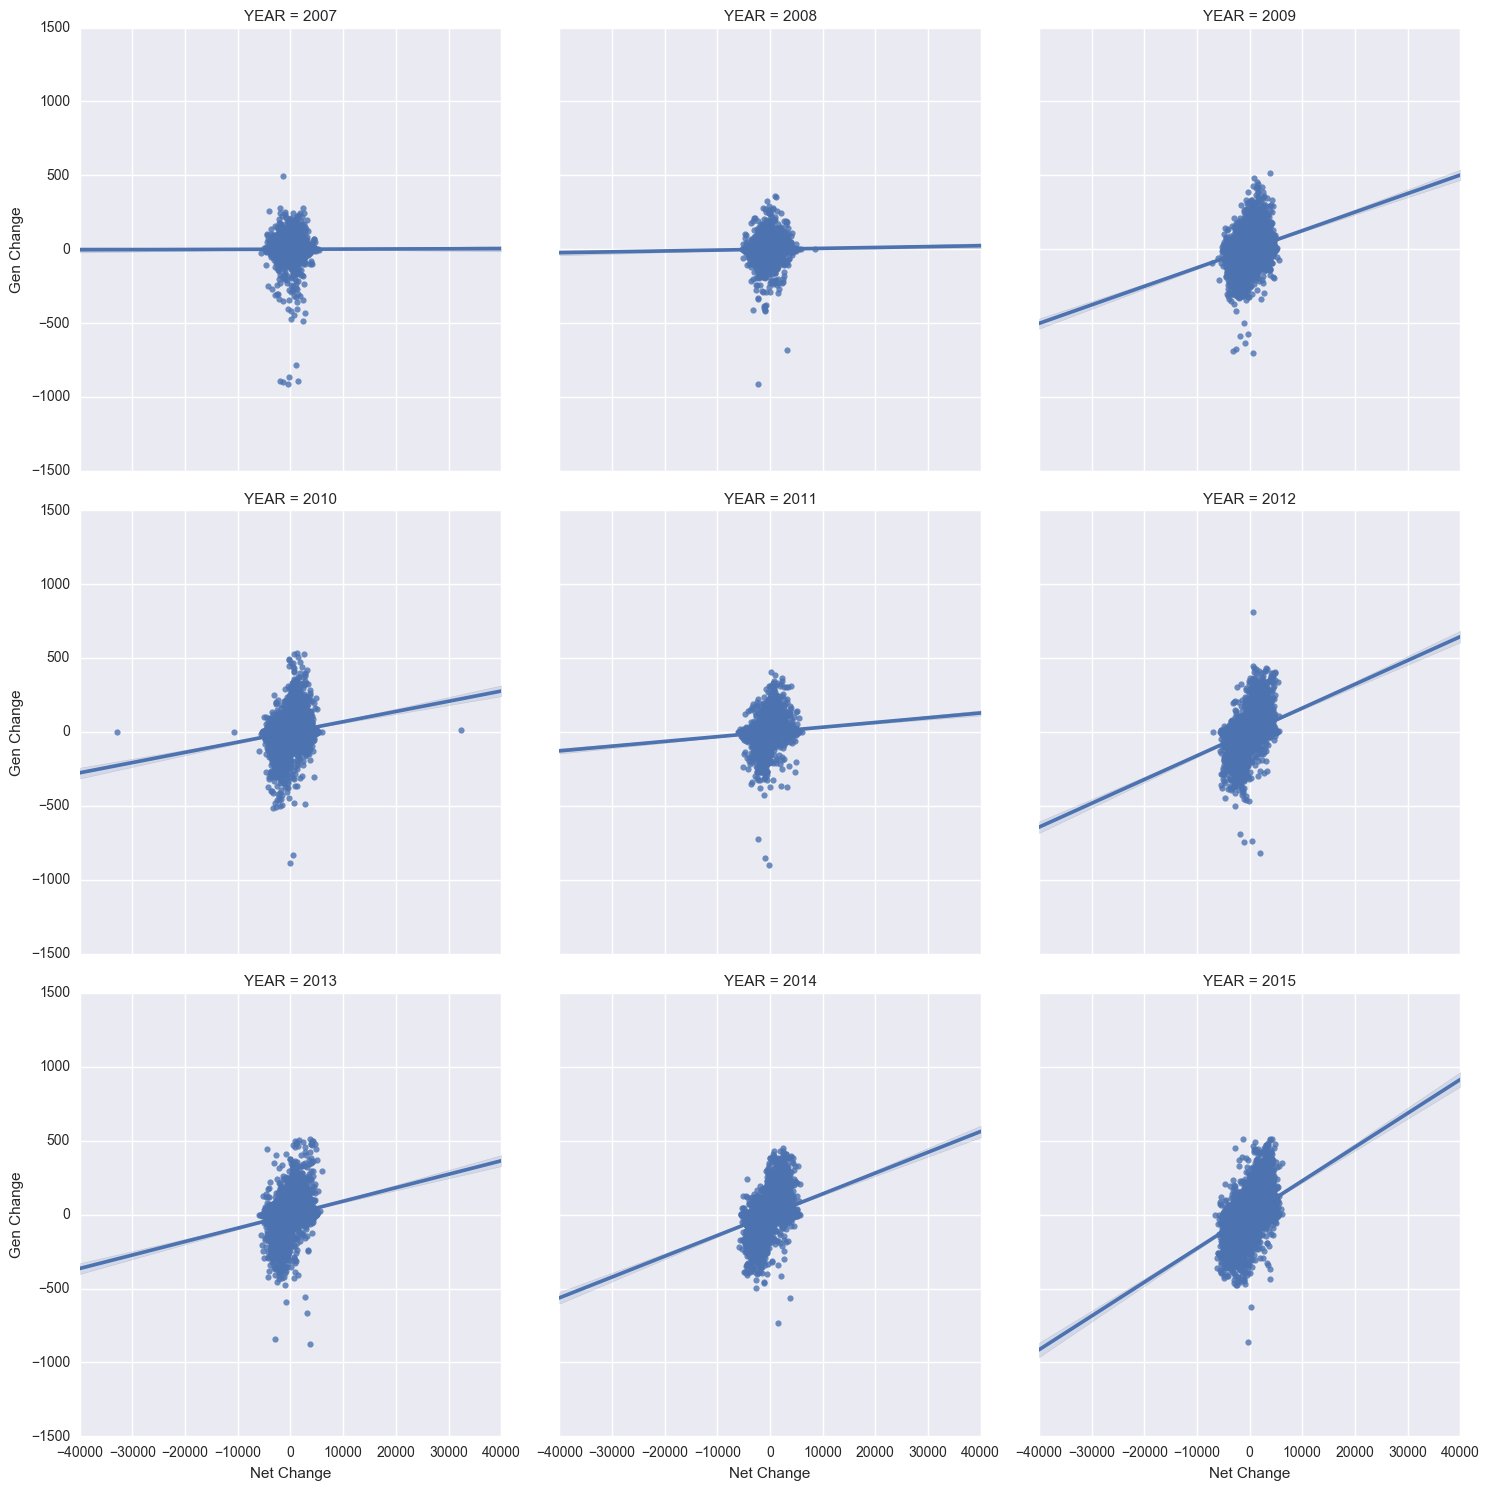

In [105]:
sns.lmplot('Net Change', 'Gen Change', test, col='YEAR', col_wrap=3)